In [81]:
import numpy as np

class State:
    def __init__(self, x, y, velx, vely, x_bounds=(None, None), y_bounds=(None, None), velx_bounds=(None, None), vely_bounds=(None, None)):
        self.x = x
        self.y = y
        self.velx = velx
        self.vely = vely

        self.x_bounds = x_bounds
        self.y_bounds = y_bounds
        self.velx_bounds = velx_bounds
        self.vely_bounds = vely_bounds

    def update(self, accx, accy, dT):
        """Kinematics"""
        self.velx += accx * dT
        self.vely += accy * dT
        self.x += self.velx * dT
        self.y += self.vely * dT

        # Clamp
        if self.x_bounds[0] != None:
            if self.x < self.x_bounds[0]:
                self.x = self.x_bounds[0]
        if self.x_bounds[1] != None:
            if self.x > self.x_bounds[1]:
                self.x = self.x_bounds[1]
        if self.y_bounds[0] != None:
            if self.y < self.y_bounds[0]:
                self.y = self.y_bounds[0]
        if self.y_bounds[1] != None:
            if self.y > self.y_bounds[1]:
                self.y = self.y_bounds[1]

        if self.velx_bounds[0] != None:
            if self.velx < self.velx_bounds[0]:
                self.velx = self.velx_bounds[0]
        if self.velx_bounds[1] != None:
            if self.velx > self.velx_bounds[1]:
                self.velx = self.velx_bounds[1]
        if self.vely_bounds[0] != None:
            if self.vely < self.vely_bounds[0]:
                self.vely = self.vely_bounds[0]
        if self.vely_bounds[1] != None:
            if self.vely > self.vely_bounds[1]:
                self.vely = self.vely_bounds[1]

    def copy(self):
        return State(self.x, self.y, self.velx, self.vely, x_bounds=self.x_bounds, y_bounds=self.y_bounds, velx_bounds=self.velx_bounds, vely_bounds=self.vely_bounds)

    def updated_state(self, actions, dT):
        actions = np.reshape(actions, (-1, 2))
        new_state = self.copy()
        for i in actions:
            new_state.update(i[0], i[1], dT)

        return new_state

    def raw_state(self):
        return [self.x, self.y, self.velx, self.vely]

    def check_bounds(self):
        if self.x_bounds[0] != None:
            if self.x < self.x_bounds[0]:
                return False
        if self.x_bounds[1] != None:
            if self.x > self.x_bounds[1]:
                return False
        if self.y_bounds[0] != None:
            if self.y < self.y_bounds[0]:
                return False
        if self.y_bounds[1] != None:
            if self.y > self.y_bounds[1]:
                return False

        if self.velx_bounds[0] != None:
            if self.velx < self.velx_bounds[0]:
                return False
        if self.velx_bounds[1] != None:
            if self.velx > self.velx_bounds[1]:
                return False
        if self.vely_bounds[0] != None:
            if self.vely < self.vely_bounds[0]:
                return False
        if self.vely_bounds[1] != None:
            if self.vely > self.vely_bounds[1]:
                return False

        return True

    def check_obstacles(self, obstacles):
        for obstacle in obstacles:
            distance = ((self.x - obstacle[0])**2 + (self.y - obstacle[1])**2)**.5
            if distance < obstacle[2]:
                return 1

        return 0

In [82]:
from scipy.optimize import minimize, NonlinearConstraint

class Optimizer:
    def __init__(self, initial_state, waypoints, dT, per_state_cost_function, final_state_cost_function, goal, obstacles, input_bounds, additional_constraints=lambda x: 0):
        self.state = initial_state
        self.waypoints = waypoints
        self.state_cost = per_state_cost_function
        self.fstate_cost = final_state_cost_function
        self.obstacles = obstacles
        self.goal = goal
        self.dT = dT
        self.additional_constraints = additional_constraints
        self.input_bounds = input_bounds

    def cost(self, x):
        state = self.state.copy()
        x = np.reshape(x, (-1, 2))

        cost = 0
        for i in x:
            state.update(i[0], i[1], self.dT)

            cost += self.state_cost(state, self.obstacles, self.goal)
            
        cost += self.state_cost(state, self.obstacles, self.goal) + self.fstate_cost(state, self.goal)

        return cost

    def constraints(self, x):
        state = self.state.copy()
        x = np.reshape(x, (-1, 2))

        cost = 0
        for i in x:
            state.update(i[0], i[1], self.dT)
            # cost += (not state.check_bounds() * 1)
            cost += state.check_obstacles(self.obstacles)

        return cost

    def calculate_optimal_input(self, initial_guess, N):
        # N actions
        # N+1 states
        actions = np.array( [initial_guess for _ in range(N)] )
        actions = actions.flatten()
        
        bounds = [ self.input_bounds for i in range(N * 2) ]
        
        # Minimize the cost function
        result = minimize(self.cost, actions, bounds=bounds)
        
        optimal_inputs = result.x
        return optimal_inputs

    

In [83]:
def dist(a, b):
    return ((b[0] - a.x) ** 2 + (b[1] - a.y) ** 2)**.5

def per_state_cost_function(state, obstacles, goal):
    cost = 0

    x_dist = (goal.x - state.x) ** 2
    y_dist = (goal.y - state.y) ** 2

    cost += (x_dist + y_dist) ** .5

    if state.velx_bounds[1] is not None and state.velx > state.velx_bounds[1]:
        cost += 100 * state.velx - state.velx_bounds[1]
    if state.velx_bounds[0] is not None and state.velx < state.velx_bounds[0]:
        cost += 100 * state.velx_bounds[0] - state.velx
    if state.vely_bounds[1] is not None and state.vely > state.vely_bounds[1]:
        cost += 100 * state.velx - state.velx_bounds[1]
    if state.vely_bounds[0] is not None and state.vely < state.vely_bounds[0]:
        cost += 100 * state.vely_bounds[0] - state.vely

    for obstacle in obstacles:
        if dist(state, obstacle) <= obstacle[2]:
            cost += 100000000 * (obstacle[2] - dist(state, obstacle))

    return cost

def final_state_cost_function(state, goal):
    x_dist = (goal.x - state.x) ** 2
    y_dist = (goal.y - state.y) ** 2
    
    if goal.velx is not None:
        vx_dist = (goal.velx - state.velx) ** 2
    else:
        vx_dist = 0

    if goal.vely is not None:
        vy_dist = (goal.vely - state.vely) ** 2
    else:
        vy_dist = 0

    return (x_dist + y_dist + vx_dist + vy_dist) * 1000
    

In [91]:
initial_state = State(0, 0, 0, 0, velx_bounds=(-5, 5), vely_bounds=(-5, 5))
goal_state = State(5, 10, 0, 0, velx_bounds=(-5, 5), vely_bounds=(-5, 5))

obstacles = [[2.5, 7.5, 1], [5.0, 3.0, 1], [3.0, 3.0, 1], [7.5, 7.5, 1]]
waypoints = [[2, 5, None, None], [4, 6, None, None], [goal_state.x, goal_state.y, goal_state.velx, goal_state.vely]]
dT = .05
N = 30

optimizer = Optimizer(initial_state, [], dT, per_state_cost_function, final_state_cost_function, goal_state, obstacles, (-3, 3))
optimal_inputs = optimizer.calculate_optimal_input([2/dT/N, 5/dT/N], N)

In [85]:
import numpy as np

new_state = initial_state.updated_state(optimal_inputs, .1)

state = [new_state.x, new_state.y, new_state.velx, new_state.vely]

print(optimal_inputs)

print(state)

[ 3.          3.          3.          3.          3.          3.
  3.          3.          3.          3.          3.          3.
  3.          3.          3.          3.          3.          3.
  3.          3.          3.          3.          3.          3.
  3.          3.          3.          3.          3.          3.
  3.          3.          3.          3.          3.          3.
  3.          3.         -0.28152945  3.         -3.          3.
 -3.          3.         -3.          3.         -3.         -2.51532576
 -3.         -3.         -3.         -3.         -3.         -3.
 -3.         -3.         -3.         -3.         -3.         -3.        ]
[9.469031760635849, 10.463927196492977, 1.971847055123498, 2.948467423561393]


In [92]:
import numpy as np

range_ = 1

total_inputs = []
state = initial_state.copy()

def within_range(state, waypoint):
    dist_ = ((waypoint[0] - state.x)**2 + (waypoint[1] - state.y)**2)**.5 
    print(dist_)
    # print("DIST", dist)

    return dist_ <= range_

while len(waypoints) > 0:
    optimizer = Optimizer(state, [], dT, per_state_cost_function, final_state_cost_function, goal_state, obstacles, (-3, 3))
    optimal_inputs = optimizer.calculate_optimal_input([(waypoints[0][0] - state.x)/N/dT, (waypoints[0][1] - state.y)/N/dT], N)[:16]
    total_inputs.extend(optimal_inputs)
    state = state.updated_state(optimal_inputs, dT)

    print(state.raw_state())

    if within_range(state, waypoints[0]):
        waypoints.pop(0)

    if within_range(state, waypoints[-1]):
        break

print(total_inputs)

[0.2700000000000001, 0.2700000000000001, 1.2000000000000002, 1.2000000000000002]
5.036447160449516
10.818770724994593
[0.8355944871566894, 1.02, 1.5745043467882802, 2.3999999999999995]
4.146834961550784
9.898619766179515
[1.3030041499426996, 2.25, 0.8858195955838942, 3.5999999999999988]
2.8369531569973265
8.586633701011177
[1.9273319881762572, 3.96, 2.0858195955838936, 4.800000000000001]
1.0425356780189423
6.776642879102076
[3.0316598264098142, 5.94, 3.285819595583893, 4.549999999999999]
1.3956797617748595
4.511979946649701
[4.1444515572043, 7.616456810841887, 2.2928535736859166, 3.6684480309768195]
3.3829748335151484
2.5324378121786473
[4.802510963291827, 8.893324733825978, 1.1210792444282478, 2.675560679426015]
4.797087156013741
1.1241583804701478
[5.01677978811341, 9.695463642226022, 0.12059791833304041, 1.48034763215726]
5.581069709781096
0.30499828605317003
[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 0.9394652513419196, 3.0, 0.9527857888800699,

[[0, 0, 0, 0], array([0.0075, 0.0075, 0.15  , 0.15  ]), array([0.0225, 0.0225, 0.3   , 0.3   ]), array([0.045, 0.045, 0.45 , 0.45 ]), array([0.075, 0.075, 0.6  , 0.6  ]), array([0.1125, 0.1125, 0.75  , 0.75  ]), array([0.1575, 0.1575, 0.9   , 0.9   ]), array([0.21, 0.21, 1.05, 1.05]), array([0.27, 0.27, 1.2 , 1.2 ]), array([0.3375, 0.3375, 1.35  , 1.35  ]), array([0.4125, 0.4125, 1.5   , 1.5   ]), array([0.495, 0.495, 1.65 , 1.65 ]), array([0.585, 0.585, 1.8  , 1.8  ]), array([0.6825, 0.6825, 1.95  , 1.95  ]), array([0.7875, 0.7875, 2.1   , 2.1   ]), array([0.9 , 0.9 , 2.25, 2.25]), array([1.02, 1.02, 2.4 , 2.4 ]), array([1.1475, 1.1475, 2.55  , 2.55  ]), array([1.2825, 1.2825, 2.7   , 2.7   ]), array([1.425, 1.425, 2.85 , 2.85 ]), array([1.575, 1.575, 3.   , 3.   ]), array([1.7325, 1.7325, 3.15  , 3.15  ]), array([1.8975, 1.8975, 3.3   , 3.3   ]), array([2.07, 2.07, 3.45, 3.45]), array([2.25, 2.25, 3.6 , 3.6 ]), array([2.4249203 , 2.4375    , 3.49840592, 3.75      ]), array([2.5946954

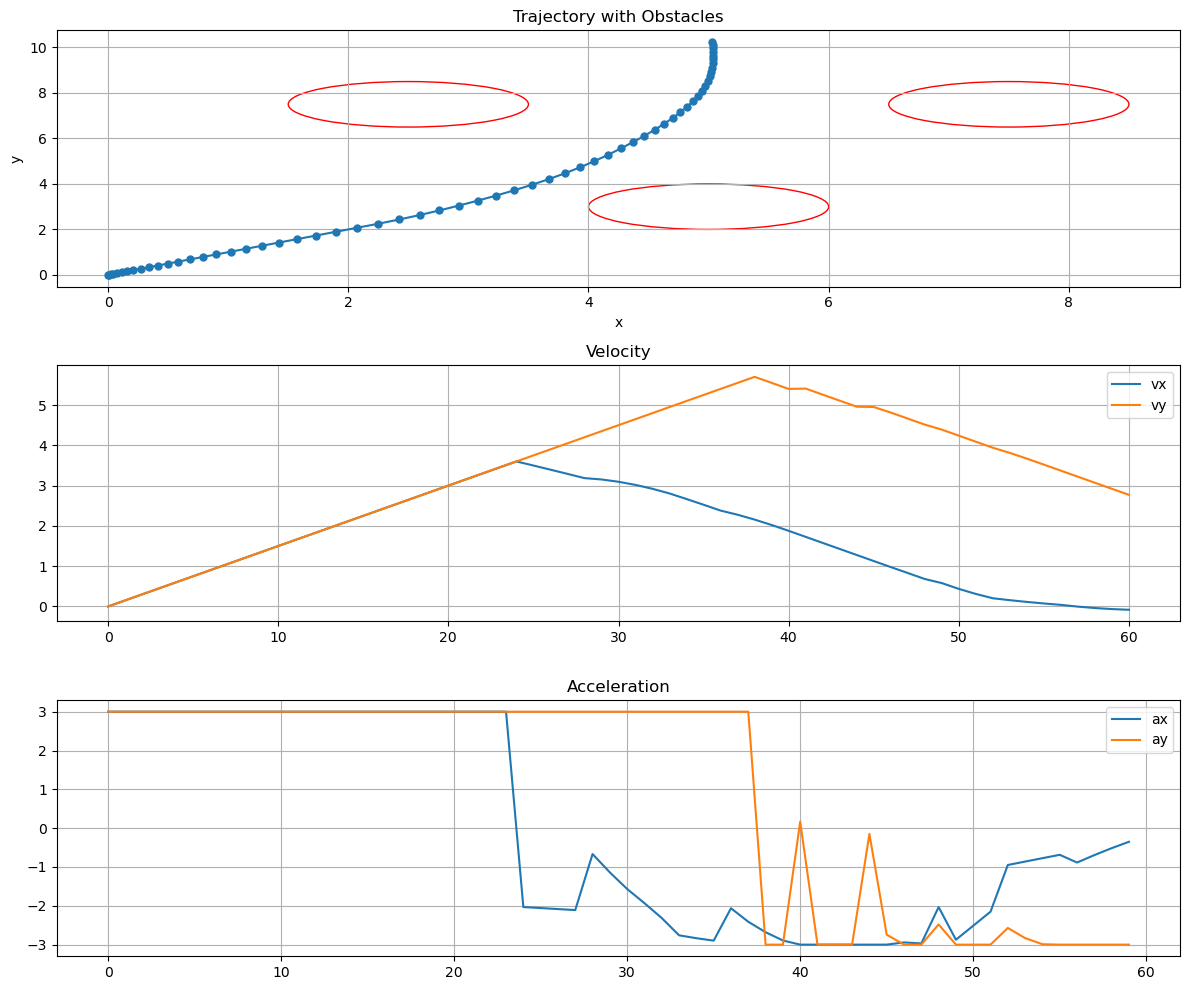

In [90]:
import matplotlib.pyplot as plt

def dynamics(state, action, dT):
    x, y, vel_x, vel_y = state
    a_x, a_y = action

    vel_x += a_x * dT
    vel_y += a_y * dT
    x += vel_x * dT
    y += vel_y * dT

    return np.array( [ x, y, vel_x, vel_y ] )

# Calculate optimal inputs
new_actions = np.reshape(total_inputs, (-1, 2))
state = initial_state.raw_state()
states = [state]
for action in new_actions:
    states.append(dynamics(states[-1], action, dT))

print(states)

# Extracting x, y, vx, vy from states
x = [state[0] for state in states]
y = [state[1] for state in states]
vx = [state[2] for state in states]
vy = [state[3] for state in states]

# Calculating ax and ay
ax = [(vx[i+1] - vx[i]) / dT for i in range(len(vx)-1)]
ay = [(vy[i+1] - vy[i]) / dT for i in range(len(vy)-1)]

# Plotting
plt.figure(figsize=(12, 10))

# Plotting trajectory on a coordinate grid
plt.subplot(3, 1, 1)
plt.plot(x, y, marker='o', linestyle='-', markersize=5)
for obstacle in obstacles:
    circle = plt.Circle((obstacle[0], obstacle[1]), obstacle[2], color='r', fill=False)
    plt.gca().add_patch(circle)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trajectory with Obstacles')
plt.grid(True)

# ax = plt.gca()
# ax.set_aspect('equal', adjustable='box')

plt.subplot(3, 1, 2)
plt.plot(vx, label='vx')
plt.plot(vy, label='vy')
plt.legend()
plt.grid(True)
plt.title('Velocity')

plt.subplot(3, 1, 3)
plt.plot(ax, label='ax')
plt.plot(ay, label='ay')
plt.legend()
plt.grid(True)
plt.title('Acceleration')

plt.tight_layout()
plt.show()